# Thick Sample Ptychography Forward Model Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a 2D forward problem with multiple probes, both iteratively and as a full system.


The forward model solves the paraxial equation:

\begin{equation}
\frac{\partial u}{\partial z} = a \frac{\partial^2 u}{\partial x^2}  + C(x, z) u,
\end{equation}
where
\begin{equation}
a := \frac{1}{2ik} \qquad \text{and} \qquad C(x, z) := \frac{k}{2i} \left(n^2(x, z) - 1\right)
\end{equation}


**$n$ defines the refractive index of the volume. $k$ is the wave number.**

### 1. Import Libraries: Sample Space and Forward Model


In [9]:
from thick_ptycho.simulation.config import SimulationConfig, ProbeType, ProbeConfig
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.forward_model.pwe.operators import BoundaryType
from thick_ptycho.simulation.simulation_space import create_simulation_space
from thick_ptycho.simulation.ptycho_object import create_ptycho_object
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.forward_model import PWEIterativeLUSolver, PWEFullLUSolver, PWEFullPinTSolver, MSForwardModelSolver
from thick_ptycho.forward_model.pwe.operators.finite_differences.boundary_condition_test import BoundaryConditionsTest
from matplotlib import pyplot as plt
import time

from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

import numpy as np

In [10]:
def _u_nm_neumann(n, k):
    a = 1j / (2 * k)
    return lambda x, z: np.exp(-a * (n**2) * (np.pi**2) * z) * np.cos(n * np.pi * x)


def _u_nm_dirichlet(n, k):
    a = 1j / (2 * k)
    return lambda x, z: np.exp(-a * (n**2) * (np.pi**2) * z) * np.sin(n * np.pi * x)


def get_exact_solution(bc_type, k, X, Z):
    """Return the analytical solution corresponding to the boundary type."""
    if bc_type in (BoundaryType.IMPEDANCE, BoundaryType.NEUMANN):
        return (
            _u_nm_neumann(1, k)(X, Z)
            + 0.5 * _u_nm_neumann(2, k)(X, Z)
            + 0.2 * _u_nm_neumann(5, k)(X, Z)
        )
    elif bc_type == BoundaryType.DIRICHLET:
        return (
            _u_nm_dirichlet(1, k)(X, Z)
            + 0.5 * _u_nm_dirichlet(5, k)(X, Z)
            + 0.2 * _u_nm_dirichlet(9, k)(X, Z)
        )
    raise ValueError(f"Unsupported BC type: {bc_type}")

In [11]:
nx = 64
nz = 32
# Wavenumber and wavelength
k = 100
wavelength = 2 * np.pi / k
limits = Limits(x=(0, 1), z=(0, 2), units="meters")

### Simulated Probe Configuration

In [12]:
bc_type = BoundaryType.DIRICHLET
def select_probe_type(bc_type):
    if bc_type in (BoundaryType.IMPEDANCE, BoundaryType.NEUMANN):
        return ProbeType.NEUMANN_TEST
    elif bc_type == BoundaryType.DIRICHLET:
        return ProbeType.DIRICHLET_TEST
    raise ValueError(f"Unsupported BC type: {bc_type}")

probe_config = ProbeConfig(
        type=select_probe_type(bc_type),
        wave_length=wavelength,
    )

sim_cfg = SimulationConfig(
    probe_config=probe_config,
    step_size_px=nx,
    nz=nz,
    spatial_limits=limits,
)

sim_space = create_simulation_space(sim_cfg)
obj = create_ptycho_object(sim_space)
probes = create_ptycho_probes(sim_space)

test_bcs = BoundaryConditionsTest(sim_space) if bc_type == BoundaryType.IMPEDANCE else None

### Discretization Parameters and Spatial Limits

In [13]:
solver = PWEFullLUSolver(
    sim_space, obj, probes,
    bc_type=bc_type.value,
    test_bcs=test_bcs
)
numerical_solution = solver.solve().squeeze()
# pdb.set_trace()

# Define coordinate grid
x = np.linspace(*limits.x, sim_space.nx)
z = np.linspace(*limits.z, sim_space.nz)
X, Z = np.meshgrid(x, z, indexing='ij')

exact_solution = get_exact_solution(bc_type, k, X, Z)

error = (exact_solution - numerical_solution)

In [14]:
def plot_error_maps(exact, numerical, error, bc_type):
    """Visualize real/imag parts of exact, numerical, and error fields."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    titles = ['Numerical', 'Exact', 'Error']

    def _plot(ax, data, title, label, vmin=None, vmax=None):
        im = ax.imshow(data, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel('z')
        ax.set_ylabel('x')
        fig.colorbar(im, ax=ax, label=label)

    real_min = min(np.real(exact).min(), np.real(exact).min())
    real_max = max(np.real(numerical).max(), np.real(exact).max())
    imag_min = min(np.imag(numerical).min(), np.imag(exact).min())
    imag_max = max(np.imag(numerical).max(), np.imag(exact).max())

    for j, (data_real, data_imag) in enumerate([(np.real(numerical), np.imag(numerical)),
                                                (np.real(exact), np.imag(exact)),
                                                (np.real(error), np.imag(error))]):
        if titles[j] == 'Error':
            _plot(axes[0, j], data_real, f"{titles[j]} (Real)", 'Re')
            _plot(axes[1, j], data_imag, f"{titles[j]} (Imag)", 'Im')
        else:
            _plot(axes[0, j], data_real, f"{titles[j]} (Real)", 'Re', real_min, real_max)
            _plot(axes[1, j], data_imag, f"{titles[j]} (Imag)", 'Im', imag_min, imag_max)

    fig.suptitle(f"{bc_type} BC — Grid {error.shape}", fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_probe_and_ew(exact, numerical, error):
    """Plot probe intensity and exit wave intensity."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 5))
    axes = axes.flatten()  # Convert to 1D array for easy indexing

    nx = exact.shape[0]

    def _plot(ax, data, title,idx=0):
        ax.plot(np.arange(nx), np.abs(data)[:,idx])
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('Amplitude')

    # Plot Exit Wave Amplitudes
    _plot(axes[0], numerical, "Numerical Exit Wave Amplitude",idx=-1)
    _plot(axes[1], exact, "Exact Exit Wave Amplitude",idx=-1)
    _plot(axes[2], error, "Error Amplitude",idx=-1)

    # Plot Probe Amplitudes
    _plot(axes[3], numerical, "Numerical Probe Amplitude",idx=0)
    _plot(axes[4], exact, "Exact Probe Amplitude",idx=0)
    _plot(axes[5], error, "Error Amplitude",idx=0)

    fig.suptitle("Probe and Exit Wave Amplitudes", fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


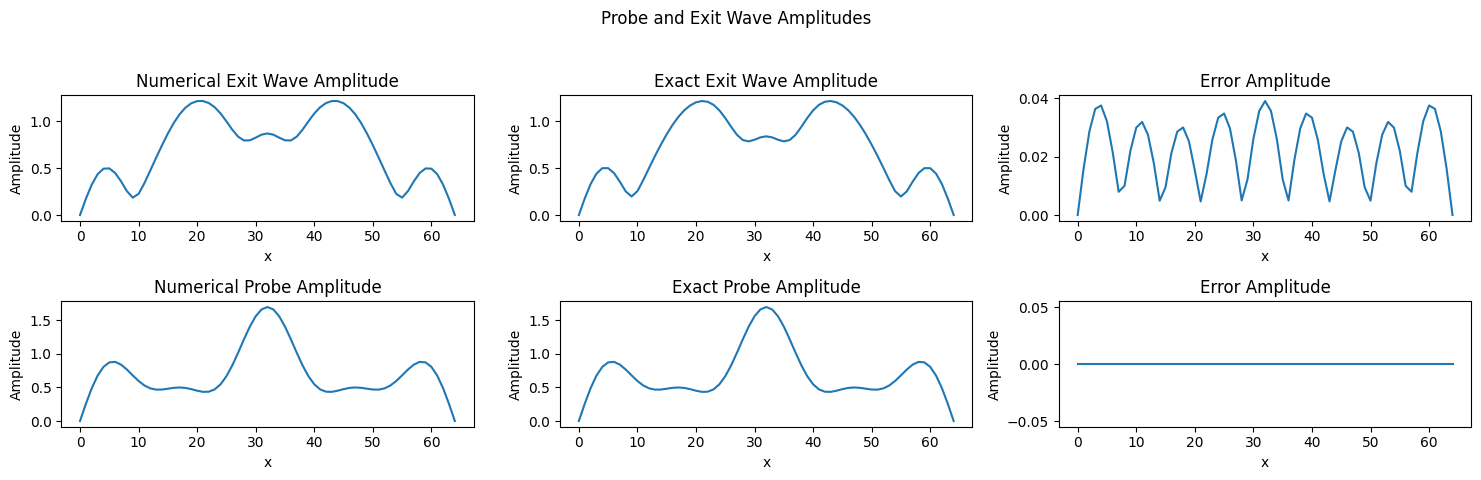

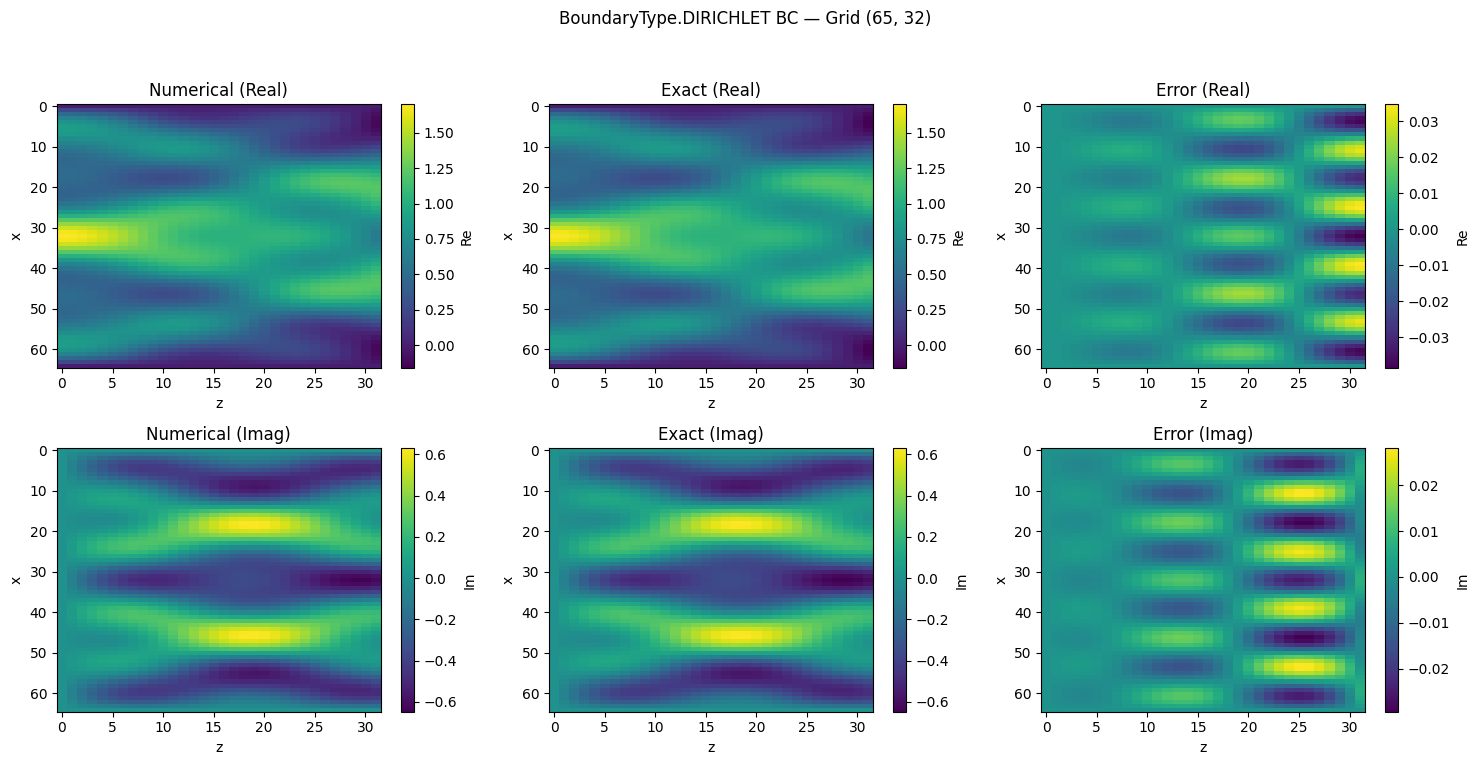

In [15]:
plot_probe_and_ew(exact_solution, numerical_solution, error)
plot_error_maps(exact_solution, numerical_solution, error, bc_type)

### 5. Solve the Forward Model


Solution is a complex propagated field, shape:

(num_projections, num_angles, num_probes, nx[,ny], nz).

In [16]:
# Solve Full Space Space, Iterative
# --- Enumerated configuration types ---
bc_type = BoundaryType.IMPEDANCE

# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe = PWEIterativeLUSolver(simulation_space,
                                ptycho_object,
                                ptycho_probes,
                                bc_type=bc_type)
# forward_model_pwe = PWEFullPinTSolver(simulation_space,
#                                 ptycho_object,
#                                 ptycho_probes,
#                                 bc_type=bc_type,
#                                 alpha=1e-3,
#                                 atol=1e-3)


# Iterative solution
u_pwe = forward_model_pwe.solve()
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe = forward_model_pwe.get_exit_waves(u_pwe)
intensities_pwe_noisy = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=True)
intensities_pwe = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe, 
                                                           poisson_noise=False)

NameError: name 'simulation_space' is not defined

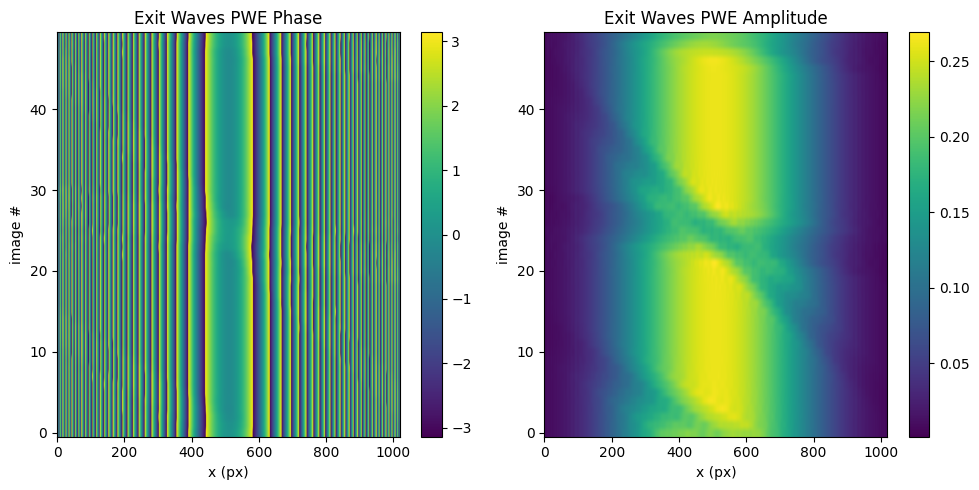

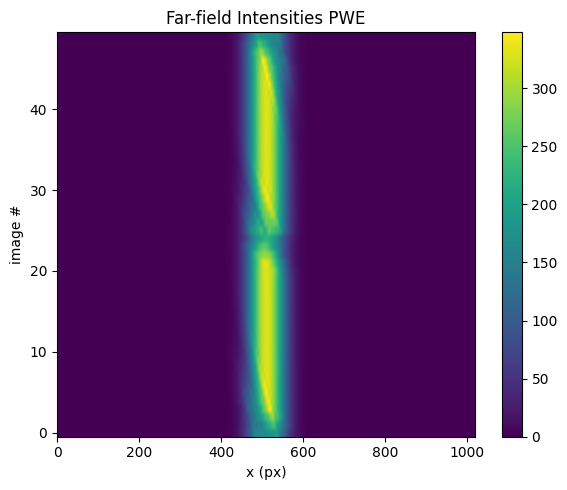

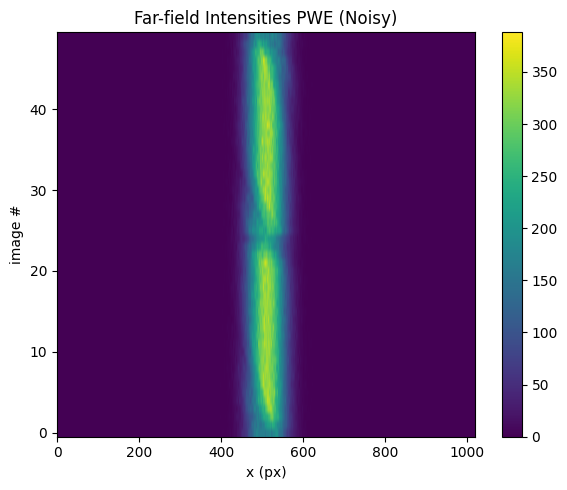

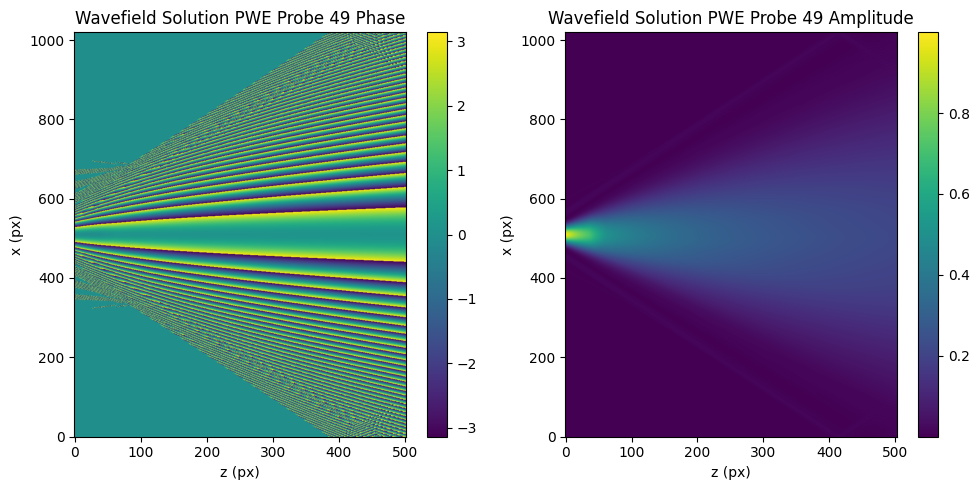

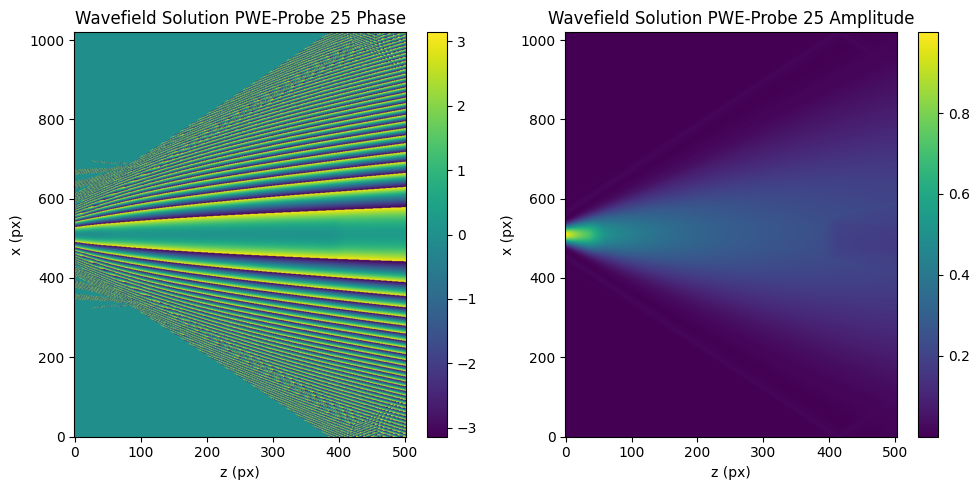

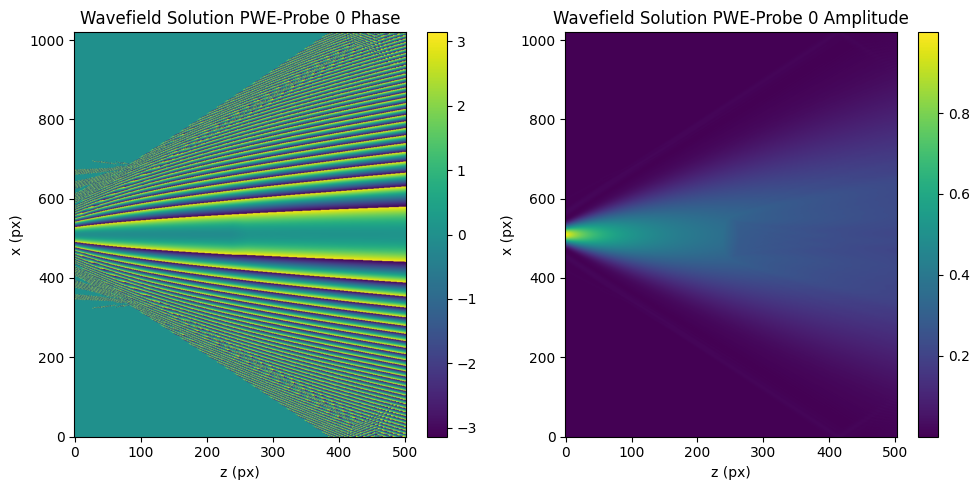

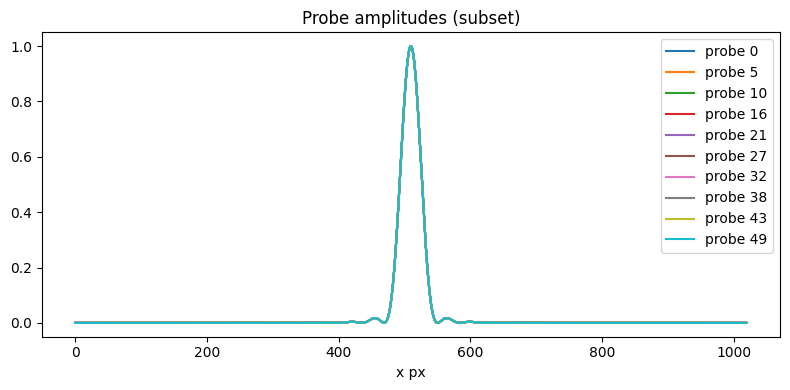

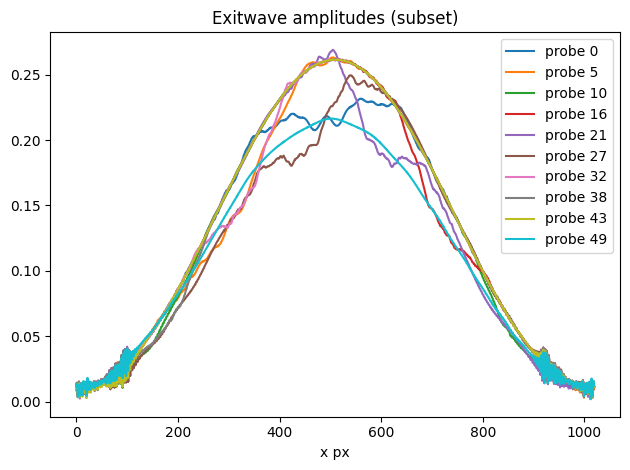

In [ ]:
simulation_space.viewer.plot_two_panels(exit_waves_pwe,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="x (px)",
                                        ylabel="image #")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe),
                                        title="Far-field Intensities PWE",
                                        xlabel="x (px)",
                                        ylabel="image #")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensities_pwe_noisy),
                                        title="Far-field Intensities PWE (Noisy)",
                                        xlabel="x (px)",
                                        ylabel="image #")

# Select Centre Probe
simulation_space.viewer.plot_two_panels(u_pwe[
                        simulation_space.num_projections//2,
                        simulation_space.num_angles//2,
                        -1, ...
                        ],
                                        view="phase_amp", 
                                        title=f"Wavefield Solution PWE Probe {simulation_space.num_probes-1}",
                                        xlabel="z (px)",
                                        ylabel="x (px)")
simulation_space.viewer.plot_two_panels(u_pwe[
                        simulation_space.num_projections//2,
                        simulation_space.num_angles//2,
                        simulation_space.num_probes//2, ...
                        ],
                                        view="phase_amp", 
                                        title=f"Wavefield Solution PWE-Probe {simulation_space.num_probes//2}",
                                        xlabel="z (px)",
                                        ylabel="x (px)")
simulation_space.viewer.plot_two_panels(u_pwe[
                        simulation_space.num_projections//2,
                        simulation_space.num_angles//2,
                        0, ...
                        ],
                                        view="phase_amp", 
                                        title=f"Wavefield Solution PWE-Probe {0}",
                                        xlabel="z (px)",
                                        ylabel="x (px)")

# plt.plot(range(simulation_space.effective_nx), u_pwe[0,0,simulation_space.num_probes//2, :, simulation_space.nz//2])
# plt.show()

plt.figure(figsize=(8,4))
plot_num_probes = min(10,simulation_space.total_scans)#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.total_scans-1, plot_num_probes, dtype=int)

u_pwe_flat = u_pwe.reshape((simulation_space.total_scans,*u_pwe.shape[-2:]))
for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe_flat[p,:,0]), label=f'probe {p}')
plt.title("Probe amplitudes (subset)")
plt.xlabel("x px"); plt.legend(); 
plt.tight_layout(); plt.show()

for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe_flat[p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x px"); plt.legend(); 
plt.tight_layout(); plt.show()


(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': ' Phase'}>,
        <Axes: title={'center': ' Amplitude'}>], dtype=object))

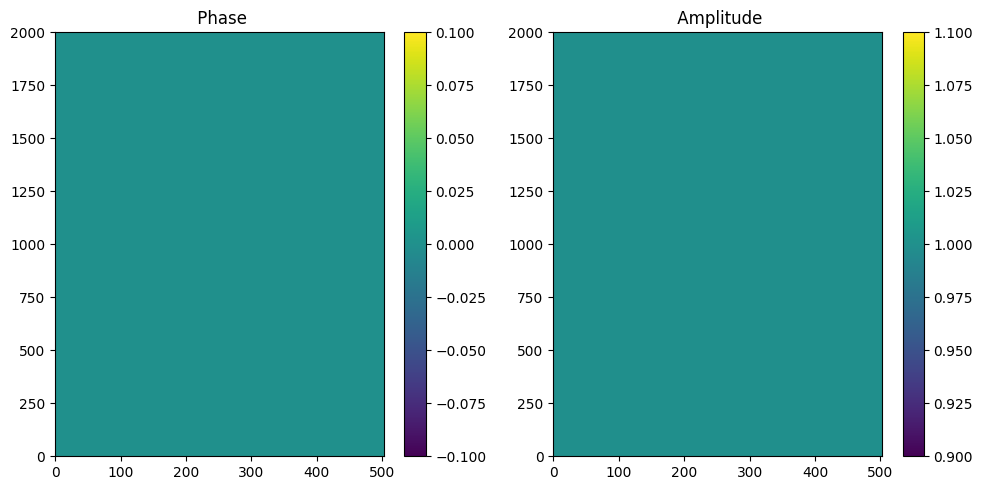

In [ ]:
# --- Create a Simultated Ptycho Object ---
ptycho_object_empty = create_ptycho_object(simulation_space)

# --- Visualize the True Object ---
simulation_space.viewer.plot_two_panels(ptycho_object_empty.n_true, view="phase_amp")

In [ ]:
# --- Create Forward Model ---
time_start = time.time()
forward_model_pwe_empty = PWEIterativeLUSolver(simulation_space,
                                ptycho_object_empty,
                                ptycho_probes,
                                bc_type=bc_type)


# Iterative solution
u_pwe_empty = forward_model_pwe_empty.solve()
time_end = time.time()
print(f"Forward model creation and solving time: {time_end - time_start:.2f} seconds.\n")
exit_waves_pwe_empty = forward_model_pwe.get_exit_waves(u_pwe_empty)
intensities_pwe_noisy_empty = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe_empty, 
                                                           poisson_noise=True)
intensities_pwe_empty = forward_model_pwe.get_farfield_intensities(exit_waves=exit_waves_pwe_empty, 
                                                           poisson_noise=False)

Forward model creation and solving time: 25.97 seconds.



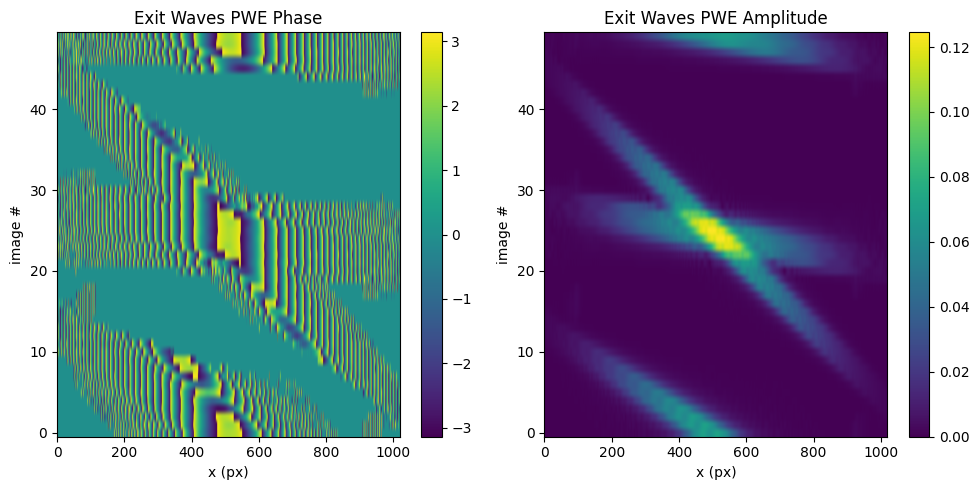

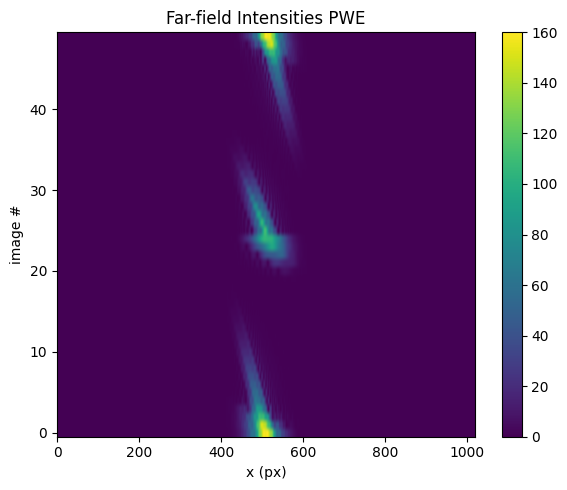

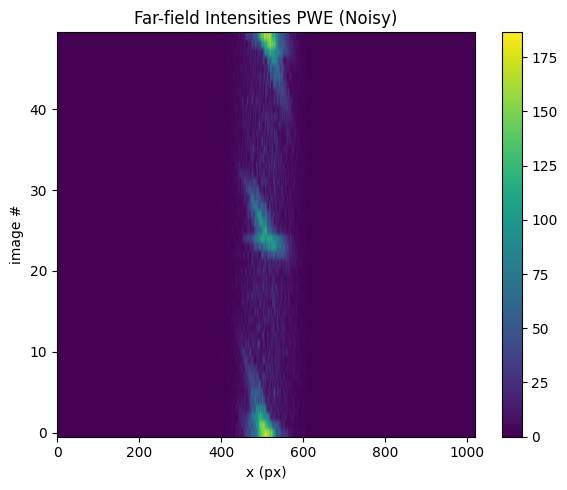

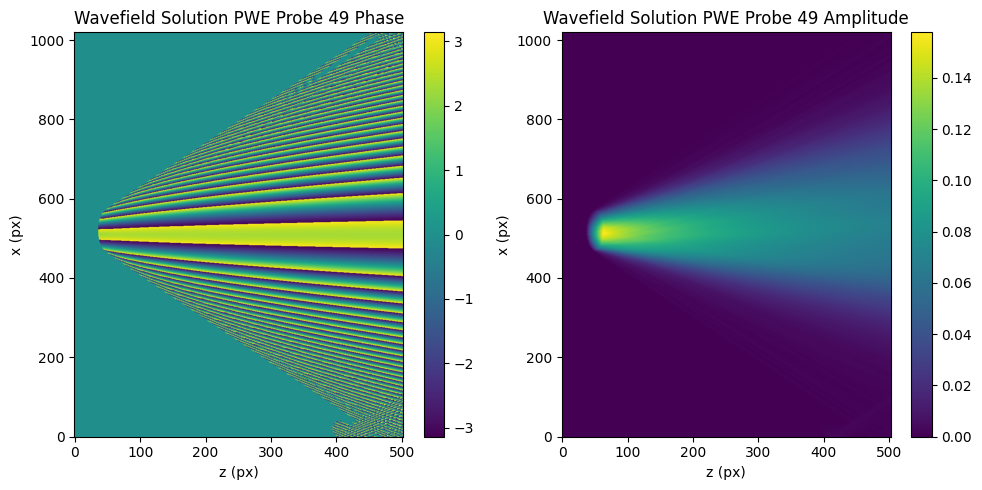

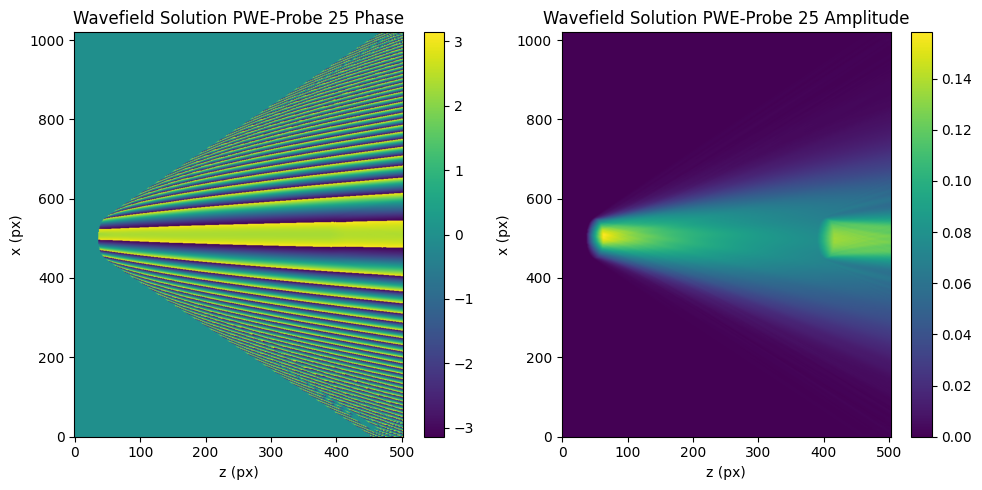

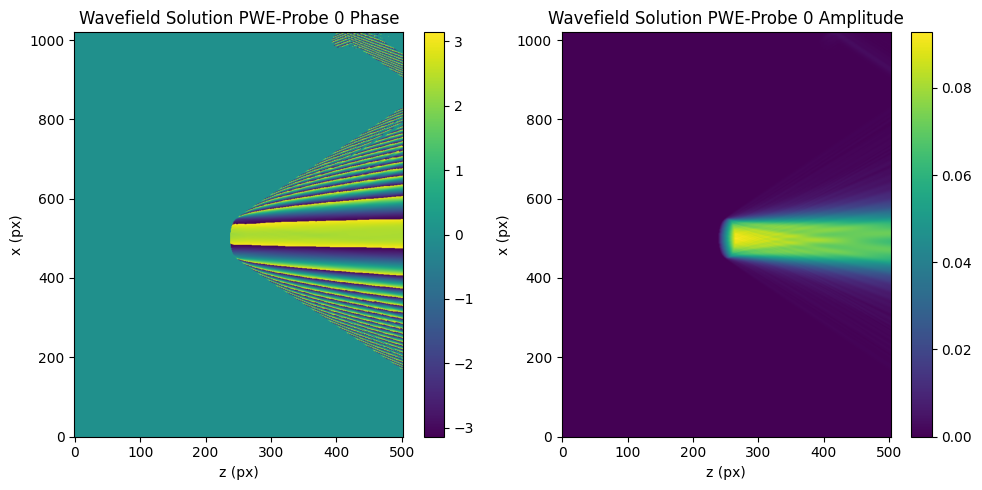

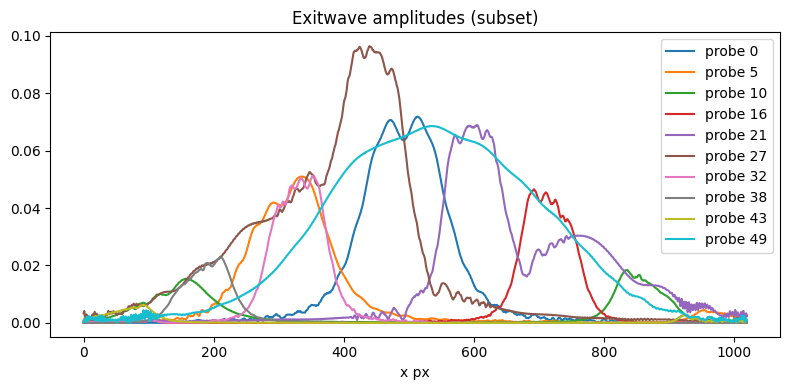

In [ ]:
exit_errors = exit_waves_pwe - exit_waves_pwe_empty
intensity_errors = intensities_pwe - intensities_pwe_empty
intensity_noisy_errors = intensities_pwe_noisy - intensities_pwe_empty
u_pwe_error = u_pwe - u_pwe_empty
simulation_space.viewer.plot_two_panels(exit_errors,
                                        view="phase_amp", 
                                        title="Exit Waves PWE",
                                        xlabel="x (px)",
                                        ylabel="image #")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensity_errors),
                                        title="Far-field Intensities PWE",
                                        xlabel="x (px)",
                                        ylabel="image #")

simulation_space.viewer.plot_single_panel(np.fft.fftshift(intensity_noisy_errors),
                                        title="Far-field Intensities PWE (Noisy)",
                                        xlabel="x (px)",
                                        ylabel="image #")

# Select Centre Probe
simulation_space.viewer.plot_two_panels(u_pwe_error[
                        simulation_space.num_projections//2,
                        simulation_space.num_angles//2,
                        -1, ...
                        ],
                                        view="phase_amp", 
                                        title=f"Wavefield Solution PWE Probe {simulation_space.num_probes-1}",
                                        xlabel="z (px)",
                                        ylabel="x (px)")
simulation_space.viewer.plot_two_panels(u_pwe_error[
                        simulation_space.num_projections//2,
                        simulation_space.num_angles//2,
                        simulation_space.num_probes//2, ...
                        ],
                                        view="phase_amp", 
                                        title=f"Wavefield Solution PWE-Probe {simulation_space.num_probes//2}",
                                        xlabel="z (px)",
                                        ylabel="x (px)")
simulation_space.viewer.plot_two_panels(u_pwe_error[
                        simulation_space.num_projections//2,
                        simulation_space.num_angles//2,
                        0, ...
                        ],
                                        view="phase_amp", 
                                        title=f"Wavefield Solution PWE-Probe {0}",
                                        xlabel="z (px)",
                                        ylabel="x (px)")

plt.figure(figsize=(8,4))
plot_num_probes = min(10,simulation_space.total_scans)#simulation_space.num_probes
probe_indices = np.linspace(0, simulation_space.total_scans-1, plot_num_probes, dtype=int)

u_pwe_error_flat = u_pwe_error.reshape((simulation_space.total_scans,*u_pwe_error.shape[-2:]))
for p in probe_indices:
    plt.plot(range(simulation_space.effective_nx), np.abs(u_pwe_error_flat[p,:,-1]), label=f'probe {p}')
plt.title("Exitwave amplitudes (subset)")
plt.xlabel("x px"); plt.legend(); 
plt.tight_layout(); plt.show()
